In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j0, j1, jv, i0, jvp
from scipy.special import jn_zeros
from scipy.integrate import quad
from scipy.integrate import dblquad
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D

## Constants and math functions

In [38]:
H = 6
R = 0.001

z = np.linspace(0, H, 70)
r = np.linspace(0, R, 70)

max_k = 40
max_n = 40

In [39]:
def find_beta_k_roots(max_k, R=1):
    # Находим первые max_k нулей функции Бесселя первого порядка j1
    j1_zeros = jn_zeros(1, max_k)
    # Вычисляем соответствующие β_k = j1_zero / R
    roots = j1_zeros / R
    return roots

In [40]:
G = 75
LAMBDA = 120
mu = 0.3
mu_0 = (LAMBDA + G)/G
alpha = 1.2e-5 

def a_k(k):
    return np.pi*(2 * k + 1) / 2

def lambda_n(n):
    return (np.pi * n) / H 

beta_k = find_beta_k_roots(max_k, R)

In [41]:
j0bk = np.empty(max_k)
for k in range(max_k):
    j0bk[k] = j0(beta_k[k])

In [42]:
ak = np.empty(max_k)
for k in range(0, max_k+1):
    ak[k-1] = a_k(k)

In [43]:
lambdan = np.empty(max_n)
for k in range(0, max_n+1):
    lambdan[k-1] = lambda_n(k)

## Solutions

### Function $T$ of temperature

The solution of the mathematical model of the heat conduction problem
$$
T(r, z)=\sum^\infty_0\frac{I_0(a_kr)}{I_0(a_kR)}f_ksin(a_kz)
$$
Where
$$ 
f_k=\int^H_0f(z)sin(a_kz)dz 
$$

In [44]:
def f(z):
    return -z**2+H*z

def f_k(k):
    integrand = lambda z: f(z) * np.sin(ak[k-1] * z)
    integral = quad(integrand, 0, H)[0]
    return integral

In [45]:
f_k_array = np.empty(max_k)
for k in range(1, max_k+1):
    result = f_k(k)
    f_k_array[k-1] = result 

C:\Users\VELIKIY\AppData\Local\Temp\ipykernel_14736\541566538.py:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral = quad(integrand, 0, H)[0]
C:\Users\VELIKIY\AppData\Local\Temp\ipykernel_14736\541566538.py:6: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral = quad(integrand, 0, H)[0]


In [46]:
def T(r, z):
    sum = np.sum((f_k_array / i0(ak * R)) * i0(ak * r) * np.sin(ak * z))
    return (2 / H) * sum

$$
T_{nk}=\int^R_0J_0(\beta_kr)rdr\int^H_0T(r,z)cos(\lambda_nz)dz \\
\lambda_n=\frac{\pi n}{2},\ \ n=0,1,... \\
\beta_k \text{ - solutions of the equation: } J_0(\beta_kR)=0 
$$

In [47]:
def T_nk(n, k, T_func):
    """
    Возвращает двойной интеграл
        ∫_{r=0}^R ∫_{z=0}^H T(r,z) * j0(beta_k[k] * r) * r * cos(lambdan[n] * z) dz dr
    """
    # Функция для dblquad: первый аргумент — z, второй — r
    def integrand(z, r):
        return T_func(r, z) * j0bk[k-1] * r * np.cos(lambdan[n-1] * z)

    # dblquad ожидает порядок: dblquad(func, r_min, r_max, z_min_fun, z_max_fun)
    result, error = dblquad(integrand,
                            0,     # r от 0
                            R,     # до R
                            lambda r: 0,  # для каждого r, z от 0
                            lambda r: H)  # до H
    return result

In [48]:
T_nk_array = np.empty((max_n, max_k))
for n in range(1, max_n+1):
    for k in range(1, max_k+1):
        result = T_nk(n, k, T)
        print(n, k)
        T_nk_array[n-1, k-1] = result

1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
2 32
2 33
2 34
2 35
2 36
2 37
2 38
2 39
2 40
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
3 20
3 21
3 22
3 23
3 24
3 25
3 26
3 27
3 28
3 29
3 30
3 31
3 32
3 33
3 34
3 35
3 36
3 37
3 38
3 39
3 40
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
4 17
4 18
4 19
4 20
4 21
4 22
4 23
4 24
4 25
4 26
4 27
4 28
4 29
4 30
4 31
4 32
4 33
4 34
4 35
4 36
4 37
4 38
4 39
4 40
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
5 16
5 17
5 18
5 19
5 20
5 21
5 22
5 23
5 24
5 25
5 26
5 27
5 28
5 29
5 30
5 31
5 32
5 33
5 34
5 35
5 36
5 37
5 38
5 39
5 40
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11

### Functions $u(r, z)$ and $w(r, z)$

$$
u(r,z)=\frac{4\mu_0\alpha}{HR^2}
\left(\sum_{k=1}^\infty \frac{\beta_k}{\left(\beta^2_k+\lambda^2_n\right)}  \frac{J_1(\beta_{k}r)}{J_0^2(\beta_{k}R)}T_{0k}
+2\sum_{k=1}^{\infty}\frac{J_1(\beta_{k}r)}{J_0^2(\beta_{k}R)}
\sum_{n=1}^\infty \frac{\beta_k}{\left(\beta^2_k+\lambda^2_n\right)} 
cos(\lambda_nz)\right)T_{nk}
$$

In [49]:
def u(r, z):
    sum_u = 0.0
    for k in range(1, max_k + 1):
        sum_u += (1 / beta_k[k-1]) * (j1(beta_k[k-1] * r) / j0(beta_k[k-1] * R)**2) * T_nk_array[0, k-1]
    for n in range(1, max_n + 1):
        for k in range(1, max_k + 1):
            sum_u += 2 * (j1(beta_k[k-1] * r) / j0(beta_k[k-1] * R)**2) * (beta_k[k-1] / (beta_k[k-1]**2 + lambdan[n-1]**2)) * np.cos(lambdan[n-1] * z) * T_nk_array[n-1, k-1]
    return (4 * mu_0 * alpha) / (H * R**2) * sum_u

$$
w(r,z)
=-\frac{8\mu_0\alpha}{HR^2}
\sum_{k=1}^{\infty}\frac{J_0(\beta_{0k}r)}{J_0^2(\beta_{0k}R)}
\sum_{n=1}^\infty \frac{\lambda_n}{\left(\beta^2_k+\lambda^2_n\right)} sin(\lambda_nz)T_{nk}
$$

In [50]:
def w(r, z):
    sum_w = 0.0
    for k in range(1, max_k + 1):
        for n in range(1, max_n + 1):
            sum_w += np.sin(lambdan[n-1] * z) * (j0(beta_k[k-1] * r) / j0(beta_k[k-1] * R)**2) * (lambdan[n-1] / (beta_k[k-1]**2 + lambdan[n-1]**2)) * T_nk_array[n-1, k-1]
    return (-8 * mu_0 * alpha) / (H * R**2) * sum_w

### Partial derivative $u(r, z)$

$$
\frac{\partial u}{\partial z}(r,z)
=-\frac{8\mu_0\alpha}{HR^2}
\sum_{k=1}^{\infty}\frac{J_1(\beta_{k}r)}{J_0^2(\beta_{k}R)}
\sum_{n=1}^\infty \frac{\lambda_n^2}{\left(\beta^2_k+\lambda^2_n\right)} sin(\lambda_nz)T_{nk}
$$

In [51]:
def partial_u_z(r, z):
    sum_u_z = 0.0
    for k in range(1, max_k + 1):
        for n in range(1, max_n + 1):
            sum_u_z += j1(beta_k[k-1] * r) / j0(beta_k[k-1] * R)**2 * (lambdan[n-1] ** 2 / (beta_k[k-1]**2 + lambdan[n-1]**2)) * np.sin(lambdan[n-1] * z)  * T_nk_array[n-1, k-1]
    return (-8 * mu_0 * alpha) / (H * R**2) * sum_u_z

In [52]:
def partial_u_r(r, z):
    sum_u = 0.0
    for k in range(1, max_k + 1):
        sum_u += (1 / beta_k[k-1]) * (jvp(beta_k[k-1] * r, 1) / j0(beta_k[k-1] * R)**2) * T_nk_array[0, k-1]
    for n in range(1, max_n + 1):
        for k in range(1, max_k + 1):
            sum_u += 2 * (jvp(beta_k[k-1] * r, 1) / j0(beta_k[k-1] * R)**2) * (beta_k[k-1] / (beta_k[k-1]**2 + lambdan[n-1]**2)) * np.cos(lambdan[n-1] * z) * T_nk_array[n-1, k-1]
    return (4 * mu_0 * alpha) / (H * R**2) * sum_u

### Partial derivative $w(r, z)$

$$
\frac{\partial w}{\partial z}(r,z)
=-\frac{8\mu_0\alpha}{HR^2}
\sum_{k=1}^{\infty}\frac{J_0(\beta_{k}r)}{J_0^2(\beta_{k}R)}
\sum_{n=1}^\infty \frac{\lambda^2_n}{\left(\beta^2_k+\lambda^2_n\right)} cos(\lambda_nz)T_{nk}
$$

In [53]:
def partial_w_z(r, z):
    sum_w_z = 0.0
    for k in range(1, max_k + 1):
        for n in range(1, max_n + 1):
            sum_w_z += j0(beta_k[k-1] * r) / j0(beta_k[k-1] * R)**2 * (lambdan[n-1]**2 / (beta_k[k-1]**2 + lambdan[n-1]**2)) * np.cos(lambdan[n-1] * z) * T_nk_array[n-1, k-1]
    return (-8 * mu_0 * alpha) / (H * R**2) * sum_w_z

### Voltages $\Theta(r, z),\  \sigma_r(r, z),\  \sigma_z(r, z)$

In [54]:
def theta(r, z):
    return 1/r * u(r, z) + partial_u_r(r, z)

In [55]:
def sigma_r(r, z):
    return 2 * G * (partial_u_r(r, z) + mu/(1-2*mu)*theta(r, z))

In [56]:
def sigma_z(r, z):
    return 2 * G * (partial_w_z(r, z) + mu/(1-2*mu)*theta(r, z))

## Plot boundary conditions

In [57]:
def plot2d(x, y, xlim, xlabel="", ylabel="", title="", plot=plt):
    plot.plot(x, y)
    if plot is plt:
        plot.xlim(0, xlim)
        plot.xlabel(xlabel)
        plot.ylabel(ylabel)
        plot.title(title)
    else:
        plot.grid()
        plot.set_xlim(0, xlim)
        plot.set_xlabel(xlabel)
        plot.set_ylabel(ylabel)
        plot.set_title(title)


$$w(r, 0)=0$$
$$\frac{\partial u}{\partial z}|_{z=0}=0$$
$$w(r, H)=0$$
$$\frac{\partial u}{\partial z}|_{z=H}=0$$
$$u(R, z)=0$$

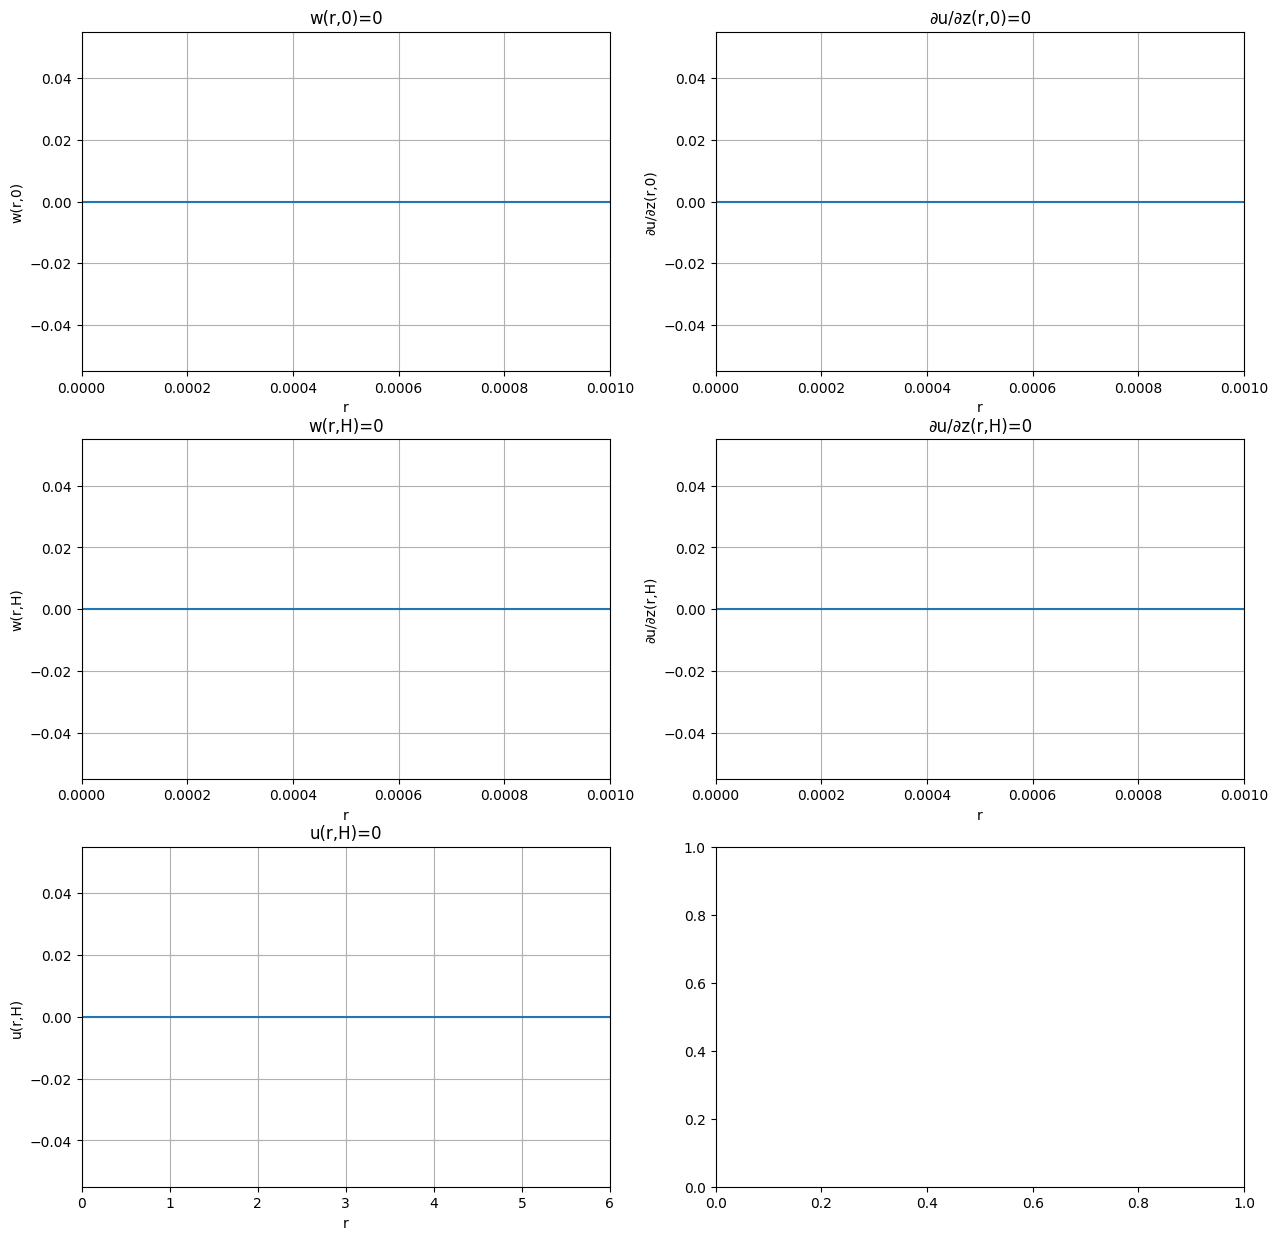

In [58]:
figure, axis = plt.subplots(3, 2)
figure.set_figheight(15)
figure.set_figwidth(15)

plot2d(r, w(r, 0), R, "r", "w(r,0)", "w(r,0)=0", axis[0, 0])
plot2d(r, partial_u_z(r, 0), R, "r", "∂u/∂z(r,0)", "∂u/∂z(r,0)=0", axis[0, 1])
plot2d(r, np.round(w(r, H), 9), R, "r", "w(r,H)", "w(r,H)=0", axis[1, 0])
plot2d(r, np.round(partial_u_z(r, H), 9), R, "r", "∂u/∂z(r,H)", "∂u/∂z(r,H)=0", axis[1, 1]) 
plot2d(z, np.round(u(R, z), 9), H, "r", "u(r,H)", "u(r,H)=0", axis[2, 0])

## Plot solutions

In [59]:
def plot3d(r, z, f, rlabel='r', zlabel='z', title=''):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.set_xlim(r[0], r[-1])
    ax.set_ylim(z[0], z[-1])
    
    r3d, z3d = np.meshgrid(r, z)
    
    print(np.max(f(r3d, z3d)))

    ax.plot_surface(r3d, z3d, np.round(f(r3d, z3d), 9), cmap='viridis')

    ax.set_title(title)
    ax.set_xlabel(rlabel)
    ax.set_ylabel(zlabel)

8.30208631117434e-14


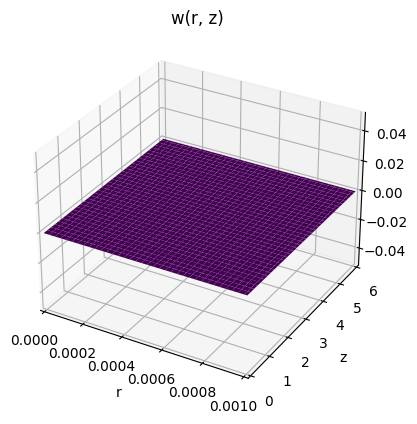

In [60]:
plot3d(r, z, w, title="w(r, z)")

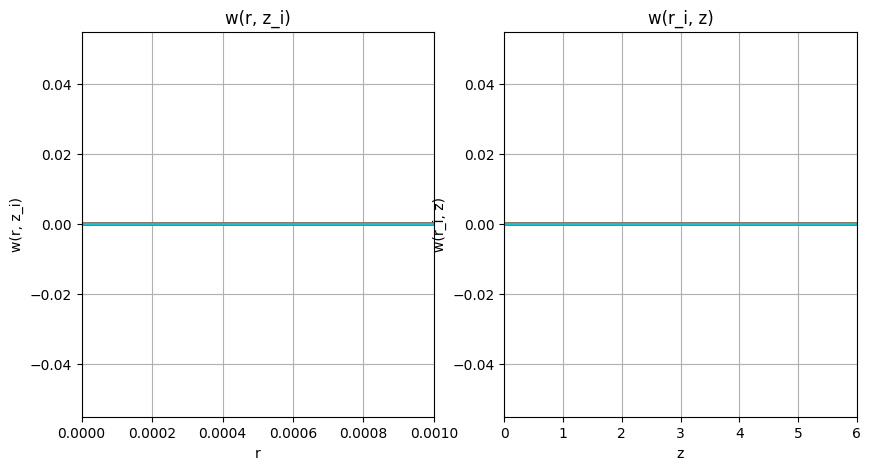

In [61]:
figure, axis = plt.subplots(1, 2)
figure.set_figheight(5)
figure.set_figwidth(10)

axis[0].grid()
axis[1].grid()

for i in z:
    plot2d(r, np.round(w(r, i), 9), R, "r", "w(r, z_i)", "w(r, z_i)", plot=axis[0])

for i in r:
    plot2d(z, np.round(w(i, z), 9), H, "z", "w(r_i, z)", "w(r_i, z)", plot=axis[1])

1.4250357043981182e-12


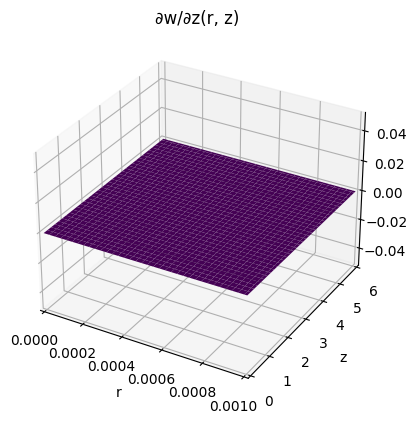

In [62]:
plot3d(r, z, partial_w_z, title="∂w/∂z(r, z)")

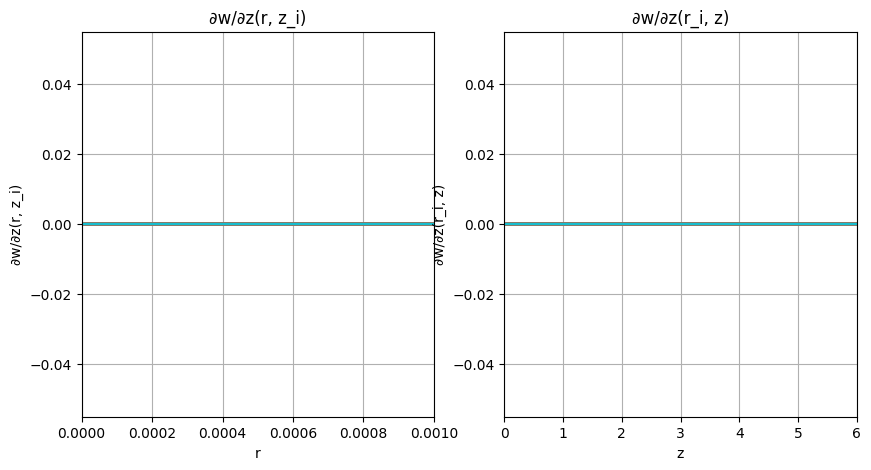

In [63]:
figure, axis = plt.subplots(1, 2)
figure.set_figheight(5)
figure.set_figwidth(10)

axis[0].grid()
axis[1].grid()

for i in z:
    plot2d(r, np.round(partial_w_z(r, i), 9), R, "r", "∂w/∂z(r, z_i)", "∂w/∂z(r, z_i)", plot=axis[0])
    
for i in r:
    plot2d(z, np.round(partial_w_z(i, z), 9), H, "z", "∂w/∂z(r_i, z)", "∂w/∂z(r_i, z)", plot=axis[1])

4.967387363221093e-11


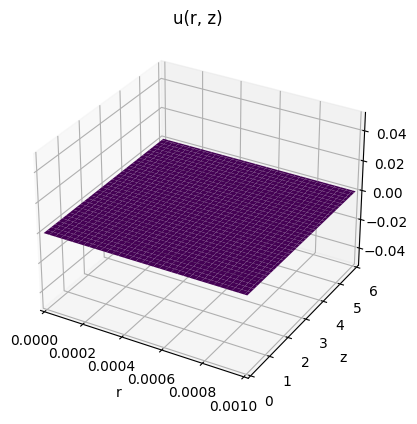

In [64]:
plot3d(r, z, u, title="u(r, z)")

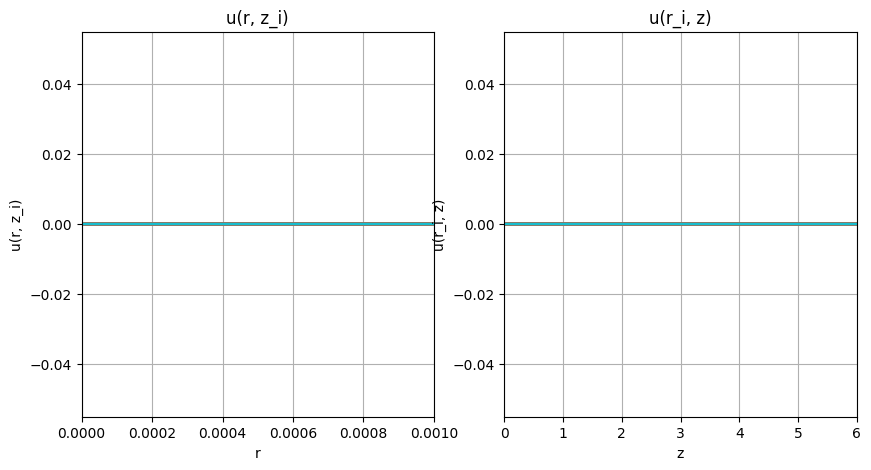

In [65]:
figure, axis = plt.subplots(1, 2)
figure.set_figheight(5)
figure.set_figwidth(10)

axis[0].grid()
axis[1].grid()

for i in z:
    plot2d(r, np.round(u(r, i), 9), R, "r", "u(r, z_i)", "u(r, z_i)", plot=axis[0])
    
for i in r:
    plot2d(z, np.round(u(i, z), 9), H, "z", "u(r_i, z)", "u(r_i, z)", plot=axis[1])

3.381702821755397e-11


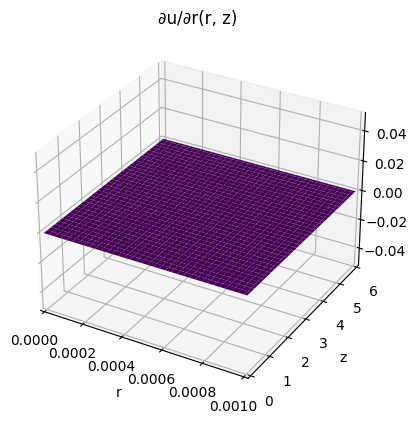

In [66]:
plot3d(r, z, partial_u_r, title="∂u/∂r(r, z)")

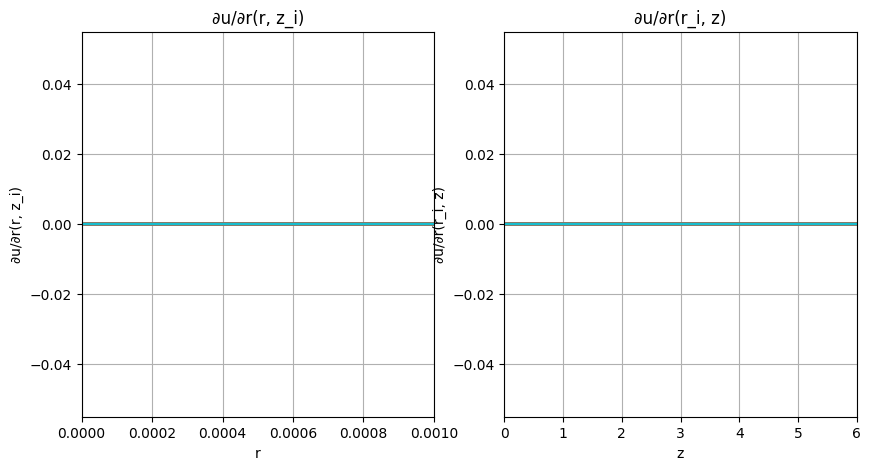

In [67]:
figure, axis = plt.subplots(1, 2)
figure.set_figheight(5)
figure.set_figwidth(10)

axis[0].grid()
axis[1].grid()

for i in z:
    plot2d(r, np.round(partial_u_r(r, i), 9), R, "r", "∂u/∂r(r, z_i)", "∂u/∂r(r, z_i)", plot=axis[0])
    
for i in r:
    plot2d(z, np.round(partial_u_r(i, z), 9), H, "z", "∂u/∂r(r_i, z)", "∂u/∂r(r_i, z)", plot=axis[1])

7.597742047626231e-13


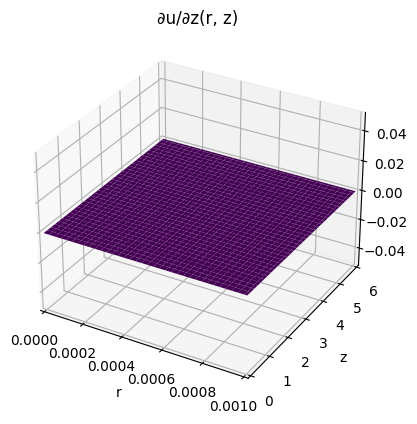

In [68]:
plot3d(r, z, partial_u_z, title="∂u/∂z(r, z)")

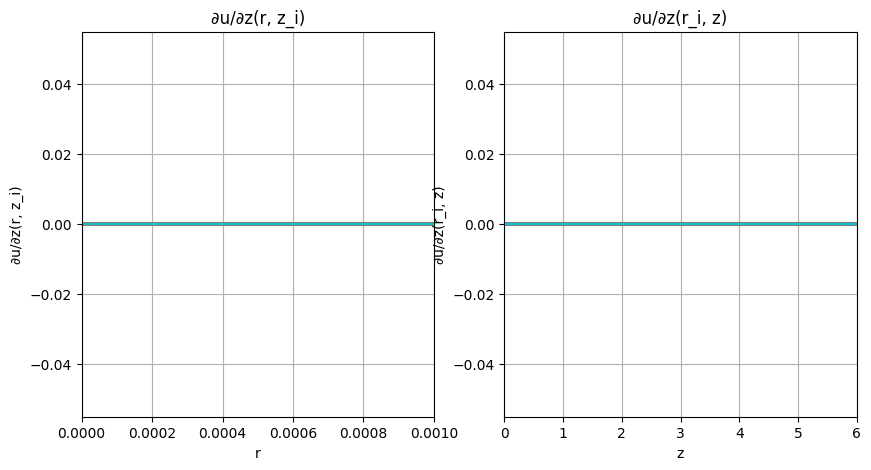

In [69]:
figure, axis = plt.subplots(1, 2)
figure.set_figheight(5)
figure.set_figwidth(10)

axis[0].grid()
axis[1].grid()

for i in z:
    plot2d(r, np.round(partial_u_z(r, i), 9), R, "r", "∂u/∂z(r, z_i)", "∂u/∂z(r, z_i)", plot=axis[0])
    
for i in r:
    plot2d(z, np.round(partial_u_z(i, z), 9), H, "z", "∂u/∂z(r_i, z)", "∂u/∂z(r_i, z)", plot=axis[1])

## Plot voltages functions

In [70]:
r = r[1:]
z = z[1:]

1.2156837060847885e-06


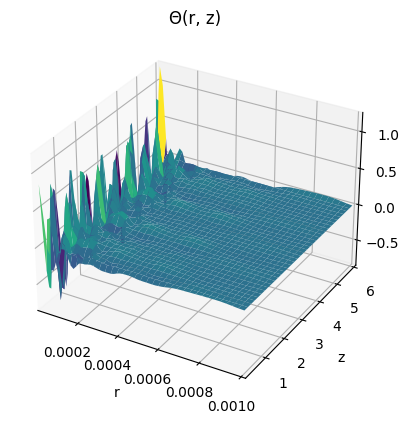

In [71]:
plot3d(r, z, theta, title="Θ(r, z)")

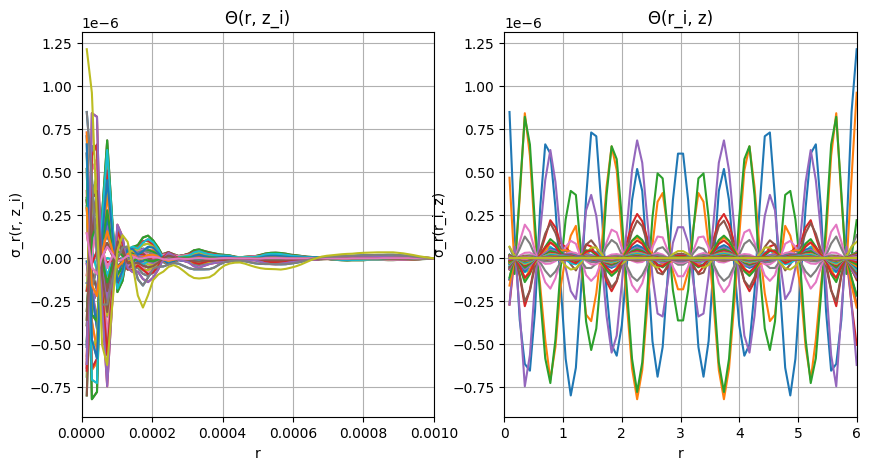

In [72]:
figure, axis = plt.subplots(1, 2)
figure.set_figheight(5)
figure.set_figwidth(10)

for i in z:
    plot2d(r, np.round(theta(r, i), 9), R, "r", "σ_r(r, z_i)", "Θ(r, z_i)", plot=axis[0])
    
for i in r:
    plot2d(z, np.round(theta(i, z), 9), H, "r", "σ_r(r_i, z)", "Θ(r_i, z)", plot=axis[1])

0.0001367694894887713


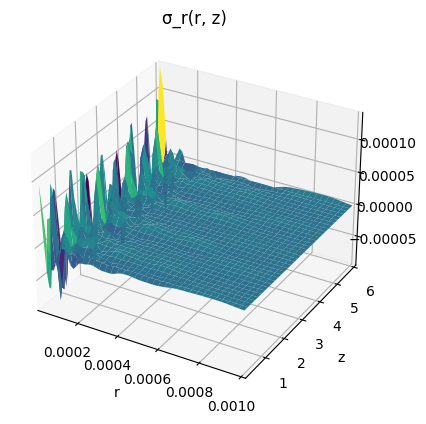

In [73]:
plot3d(r, z, sigma_r, title="σ_r(r, z)")

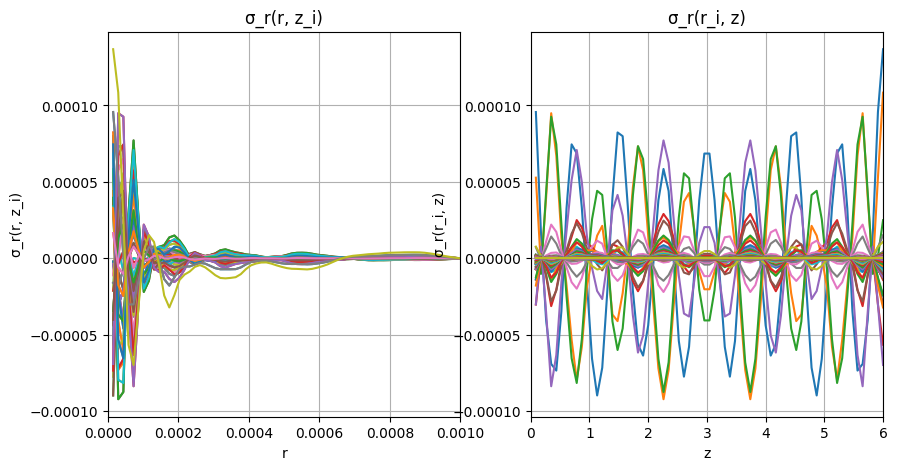

In [74]:
figure, axis = plt.subplots(1, 2)
figure.set_figheight(5)
figure.set_figwidth(10)

for i in z:
    plot2d(r, np.round(sigma_r(r, i), 9), R, "r", "σ_r(r, z_i)", "σ_r(r, z_i)", plot=axis[0])
    
for i in r:
    plot2d(z, np.round(sigma_r(i, z), 9), H, "z", "σ_r(r_i, z)", "σ_r(r_i, z)", plot=axis[1])

0.00013676461389618516


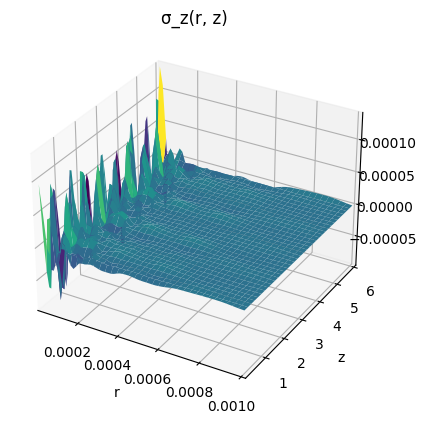

In [75]:
plot3d(r, z, sigma_z, title="σ_z(r, z)")

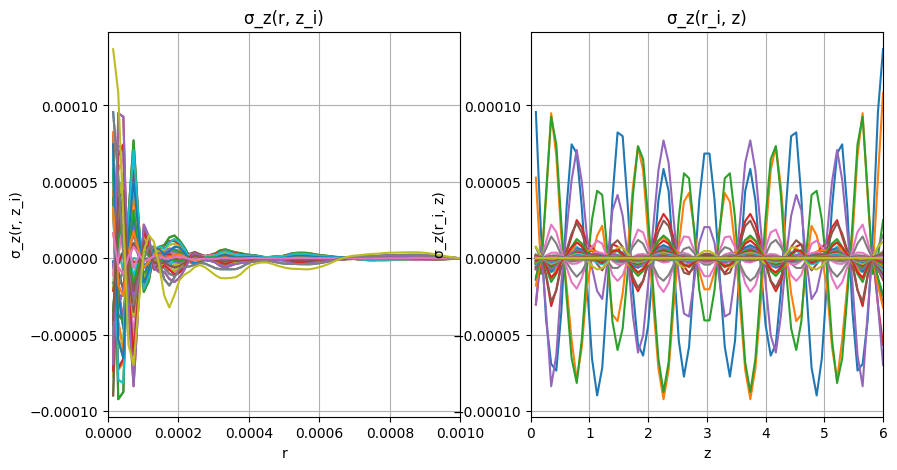

In [76]:
figure, axis = plt.subplots(1, 2)
figure.set_figheight(5)
figure.set_figwidth(10)

for i in z:
    plot2d(r, np.round(sigma_z(r, i), 9), R, "r", "σ_z(r, z_i)", "σ_z(r, z_i)", plot=axis[0])
    
for i in r:
    plot2d(z, np.round(sigma_z(i, z), 9), H, "z", "σ_z(r_i, z)", "σ_z(r_i, z)", plot=axis[1])

## Cylinder's visualization

In [77]:
def draw_cylinder(colors=['red', 'blue', 'blue'] ,radius=1, height=2, resolution=30):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Генерация координат для боковой поверхности
    theta = np.linspace(0, 2 * np.pi, resolution)
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    z_bottom = np.zeros_like(x)
    z_top = np.ones_like(x) * height
    
    # Рисуем боковую поверхность
    for i in range(len(x) - 1):
        verts = [[(x[i], y[i], z_bottom[i]),
                  (x[i+1], y[i+1], z_bottom[i+1]),
                  (x[i+1], y[i+1], z_top[i+1]),
                  (x[i], y[i], z_top[i])]]
        ax.add_collection3d(Poly3DCollection(verts, color=colors[0], edgecolor='k'))
    
    # Рисуем верхнюю и нижнюю крышки
    ax.add_collection3d(Poly3DCollection([list(zip(x, y, z_bottom))], color=colors[1], edgecolor='k'))
    ax.add_collection3d(Poly3DCollection([list(zip(x, y, z_top))], color=colors[2], edgecolor='k'))
    
    # Настройки осей
    ax.set_xlim([-radius, radius])
    ax.set_ylim([-radius, radius])
    ax.set_zlim([0, height])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_box_aspect([1, 1, height / radius])
    
    plt.show()

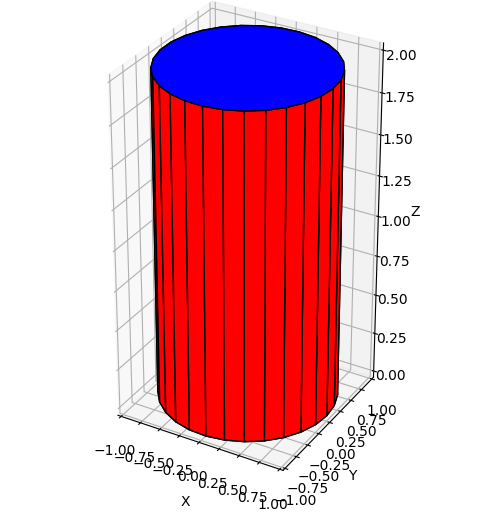

In [78]:
draw_cylinder()

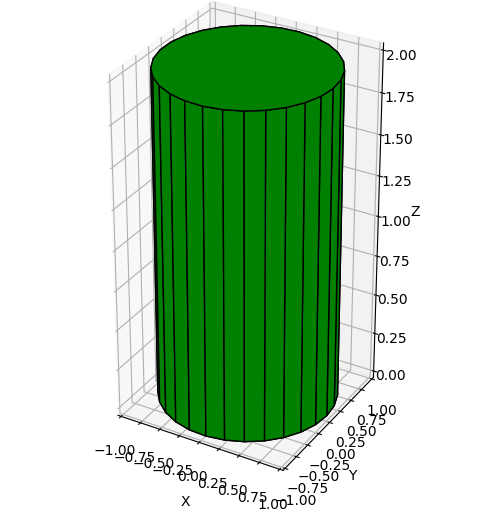

In [79]:
draw_cylinder(['green', 'green', 'green'])

In [80]:
def draw_pol_cylinder(outer_radius=1, inner_radius=0.7, height=2, resolution=30):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Генерация координат для внешней и внутренней боковых поверхностей
    theta = np.linspace(0, 2 * np.pi, resolution)
    outer_x = outer_radius * np.cos(theta)
    outer_y = outer_radius * np.sin(theta)
    inner_x = inner_radius * np.cos(theta)
    inner_y = inner_radius * np.sin(theta)
    z_bottom = np.zeros_like(outer_x)
    z_top = np.ones_like(outer_x) * height
    
    # Рисуем внешнюю боковую поверхность
    for i in range(len(outer_x) - 1):
        verts = [[(outer_x[i], outer_y[i], z_bottom[i]),
                  (outer_x[i+1], outer_y[i+1], z_bottom[i+1]),
                  (outer_x[i+1], outer_y[i+1], z_top[i+1]),
                  (outer_x[i], outer_y[i], z_top[i])]]
        ax.add_collection3d(Poly3DCollection(verts, color='green', edgecolor='k'))
    
    # Рисуем внутреннюю боковую поверхность
    for i in range(len(inner_x) - 1):
        verts = [[(inner_x[i], inner_y[i], z_bottom[i]),
                  (inner_x[i+1], inner_y[i+1], z_bottom[i+1]),
                  (inner_x[i+1], inner_y[i+1], z_top[i+1]),
                  (inner_x[i], inner_y[i], z_top[i])]]
        ax.add_collection3d(Poly3DCollection(verts, color='green', edgecolor='k'))
    
    # Рисуем верхнюю и нижнюю крышки как кольца
    ax.add_collection3d(Poly3DCollection([list(zip(outer_x, outer_y, z_bottom)) + list(zip(inner_x[::-1], inner_y[::-1], z_bottom))], color='green', edgecolor='k'))
    ax.add_collection3d(Poly3DCollection([list(zip(outer_x, outer_y, z_top)) + list(zip(inner_x[::-1], inner_y[::-1], z_top))], color='green', edgecolor='k'))
    
    # Настройки осей
    ax.set_xlim([-outer_radius, outer_radius])
    ax.set_ylim([-outer_radius, outer_radius])
    ax.set_zlim([0, height])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_box_aspect([1, 1, height / outer_radius])
    
    plt.show()


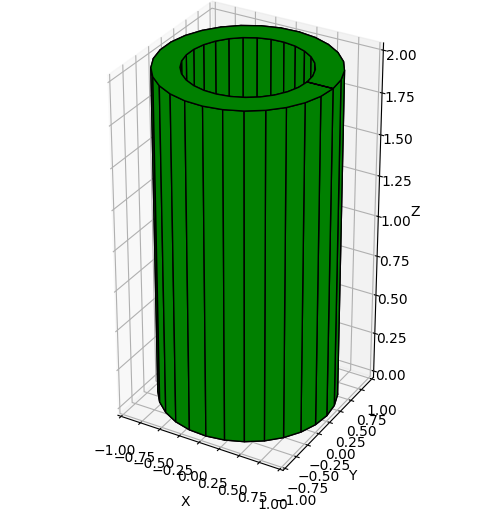

In [81]:
draw_pol_cylinder()